# Airline Reliability
This notebook is using the airline delay causes dataset from Kaggle, https://www.kaggle.com/giovamata/airlinedelaycauses.

The analysis of this data will aim to anser the following questions:

1. Which day of the week is the worst day for flight arrival delays? (Answered)

2. Is there a period throughout the year where arrival delays are higher than average?

3. Which flight routes have the most arrival delay?

4. Which airline is the most reliable?

5. What is the leading cause for arrival delay in airlines?

In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

from scipy.interpolate import spline

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

df = pd.read_csv('./source/DelayedFlights.csv', index_col=0)                
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [309]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

Now that the data is imported the value add of each column needs to be determined.

Columns may need dropping or transforming depending on content.

The value of some columns can be determined by their description; Month, DayofMonth, DayofWeek, CRSDepTime, CRSArrTime, UniqueCarrier, CSRElapsedTime, ArrDelay, DepDelay, Origin, Dest, Distance are all of use in the prediction of delayed flights.

Columns with reported statistics, as opposed to plan are; Month, DayofMonth, DayOfWeek, DepTime, ArrTime, UniqueCarrier, ActualElapsedTime, AirTime, ArrDelay, DepDelay, Origin, Dest, Distance, and the various Delay fields. 

Fields that do not inititally appear of value are; Year, FlightNum, TailNum, TaxiIn, TaxiOut, Cancelled, CancellationCode & Diverted.

In [310]:
cols_to_check = ['Year', 'FlightNum', 'TailNum', 'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted']

for col in cols_to_check:
    print(df[col].value_counts().head())
    print('\n')

2008    1936758
Name: Year, dtype: int64


16    1586
50    1550
40    1507
15    1471
44    1447
Name: FlightNum, dtype: int64


N325SW    965
N676SW    951
N658SW    945
N313SW    937
N308SA    936
Name: TailNum, dtype: int64


4.0    323427
5.0    314063
6.0    239676
3.0    234686
7.0    177889
Name: TaxiIn, dtype: int64


11.0    129633
10.0    129556
12.0    126355
13.0    119526
9.0     118894
Name: TaxiOut, dtype: int64


0    1936125
1        633
Name: Cancelled, dtype: int64


N    1936125
B        307
A        246
C         80
Name: CancellationCode, dtype: int64


0    1929004
1       7754
Name: Diverted, dtype: int64




<b>Year:</b> All fields are from 2008, this column will be dropped. <br>
<b>FlightNum:</b> The flight number is not relevant at this level of analysis, this column will be dropped. <br>
<b>TailNum:</b> The tail number is not relevant at this level of analysis, this column will be dropped. <br>
<b>TaxiIn/TaxiOut:</b> The taxi times are not relavent as delay times are recorded separately, these columns will be dropped.  <br>
<b>Cancelled:</b> Cancelled flights will not have a dealy time, this column will be dropped. <br>
<b>CancellationCode:</b> Cancelled flights are dropped so this column holds no value, this column will be dropped. <br>
<b>Diverted:</b> Diverted flights may contribute to delays, this column will be re-analyzed once data is cleaned.  

In [311]:
df = df.drop(['Year','FlightNum','TailNum','TaxiIn','TaxiOut','Cancelled','CancellationCode'], axis=1)

Inital columns have been dropped, now the data needs to be checkhed for validity and consistency.

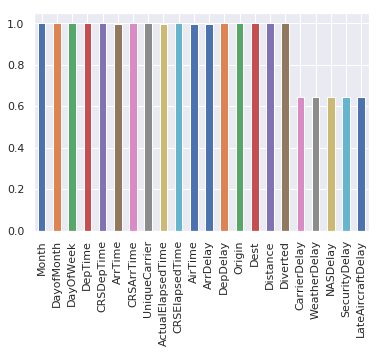

In [312]:
(df.count() / df.shape[0]).plot(kind="bar");

As seen above the various delay cause fields are missing approximately 35% of their data. <br>
One of the questions in the anlaysis of this data is to identify the leading cause of delays, to accomodate this any row containing no data in the delay cuase fields will be dropped.

In [313]:
pre_na_drop = df.shape[0]

In [314]:
df = df.dropna(subset=['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'])
df = df.reset_index()

In [326]:
df = df.drop('index', axis=1)

In [315]:
print('Remaining rows from original dataset:',round((df.shape[0] / pre_na_drop) * 100, 2))

Remaining rows from original dataset: 64.41


The missing data has now been removed, next is to map any categorical or object data that is not in an appropriate format. <br>

The three fields identified below, Dest, Origin & Unique Carrier will be transformed.

<b>UniqueCarrier:</b> This field will be mapped to a numerical value and a dictionary maintained for reverse transforms. </br>
<b>Origin/Dest:</b> These fields will be concatenated into the format `Origin - Dest` and then go through the mapping process as above. </br>

In [316]:
object_data = set(df.select_dtypes(include=['object']).columns)

object_data

{'Dest', 'Origin', 'UniqueCarrier'}

In [317]:
df['Route'] = df['Origin'] + " - " + df['Dest']
df = df.drop(['Dest','Origin'], axis=1)

In [319]:
uniqueRouteDict = dict(enumerate(df['Route'].astype('category').cat.categories))
df['Route'] = df['Route'].astype('category').cat.codes

In [320]:
uniqueCarrierDict = dict(enumerate(df['UniqueCarrier'].astype('category').cat.categories))
df['UniqueCarrier'] = df['UniqueCarrier'].astype('category').cat.codes

In [335]:
float_data = set(df.select_dtypes(include=['float64']).columns)

for col in float_data:
    df[col] = df[col].astype('int16')

The dataframe is reporting a mix of float and int data type, within this data there is no need for the float data type so it has been converted to int.

At this point all categorical data has been transformed appropriately.

## Days of the week

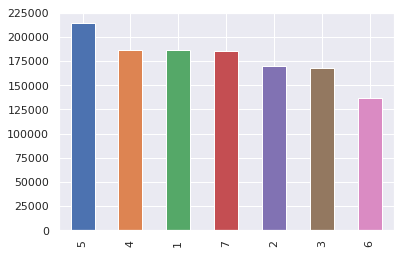

In [346]:
df['DayOfWeek'].value_counts()
(df['DayOfWeek'].value_counts()).plot(kind="bar");

The above chart shows the day of the week for flights, 1 = Monday, 7 = Sunday.
The most popular day of the week to travel on is Friday and Saturday being the least popular.
Every other day is in a median range.

In [356]:
delay_by_day = (df.groupby('DayOfWeek', as_index=False)
       .agg({'ArrDelay':'mean','CarrierDelay':'mean', 'WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'}))

In [357]:
delay_by_day.sort_values(by='ArrDelay')

,DayOfWeek,ArrDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2,3,61.041335,19.213996,3.387808,14.709697,0.087040,23.642793
3,4,61.348052,18.360238,3.647854,14.624468,0.083608,24.631885
5,6,62.151388,22.038966,3.990661,12.518273,0.146978,23.456511
0,1,62.752050,19.376672,3.346693,14.476062,0.079685,25.472937
4,5,63.433851,17.795664,3.580344,15.478843,0.085355,26.493645
1,2,65.056200,18.367989,4.120911,17.078724,0.076329,25.412248
6,7,66.890671,20.009450,3.953517,15.687468,0.086309,27.153928


The data above shows that flying on a Sunday is likely to result in the most delays. A Wedneday is the least likely to result in delays. 

The variance for overall delay could be considered low, there is an approximately five minute difference between Sunday and Wednesday. 

## Months of the year

In [362]:
delay_by_month = (df.groupby('Month', as_index=False)
       .agg({'ArrDelay':'mean','CarrierDelay':'mean', 'WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'}))

In [363]:
delay_by_month.sort_values(by='Month')

,Month,ArrDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,63.047133,19.354470,3.530053,14.407299,0.102711,25.652600
1,2,64.170790,18.507422,4.207895,14.532052,0.086024,26.837397
2,3,62.081595,19.188412,3.610672,13.664191,0.111840,25.506481
3,4,59.414580,19.657297,2.748136,13.616508,0.077583,23.315056
4,5,58.371703,18.068723,2.523910,14.009781,0.102340,23.666948
5,6,66.167549,18.124587,4.179695,17.568216,0.077266,26.217786
6,7,68.081228,20.168679,4.648513,17.511306,0.109670,25.643061
7,8,64.612224,21.107413,3.961263,14.723465,0.073378,24.746705
8,9,57.814318,21.715276,2.807024,14.169841,0.085064,19.037111
9,10,54.341281,19.950980,1.836139,12.343436,0.090892,20.119834


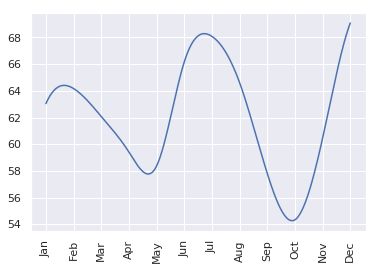

In [502]:
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

arr_del = delay_by_month['ArrDelay']
month_del = delay_by_month['Month']

xnew = np.linspace(T.index.min(), T.index.max(), 300)

power_smooth = spline(T.index,list(T),xnew)

plt.xticks(np.arange(12), month_map.values(), rotation=90)

plt.plot(xnew,power_smooth)

The graph above indicates that the Summer period, May, June, July and Winter period, December, January, February result in a spike of delays. <br>
Autumn and Spring provide the least amount of delay on average with Spring being minutely ahead.

## Performance by Route

uniqueRoutesCount = df['Route'].value_counts()
sns.set(style="darkgrid")
sns.barplot(uniqueRoutesCount.index, uniqueRoutesCount.values)
plt.title('Distribution')
plt.ylabel('Occurences')
plt.xlabel('UniqueCarrier')
plt.show()

The above bar plot is not overly useful except to show there is a large variance in the number of flights on each route.
This can cause a data skew, see below:

In [205]:
delay_by_route = (df.groupby('Route', as_index=False)
       .agg({'CarrierDelay':'mean', 'WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'}))

delay_by_route['TotalDelay'] = delay_by_route['CarrierDelay'] + delay_by_route['WeatherDelay'] + delay_by_route['NASDelay'] + delay_by_route['SecurityDelay'] + delay_by_route['LateAircraftDelay']

delay_by_route.sort_values(by='TotalDelay')

route_979 = delay_by_route[delay_by_route['Route'] == 979]

route_979['Route'] = route_979['Route'].map(uniqueRouteDict)

route_979

,Route,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TotalDelay
979,CMI - SPI,545.0,0.0,0.0,0.0,30.0,575.0


As can be seen above there is a total delay of 575 minutes, almost 10 hours! There is only one record for this route in the dataset. The flight from Champaign, Illinois (CMI) to Springfield, Illinois (SPI).

I have made the decision to drop any route with less than fifty-two records, this is based on one flight per week to provide averages and estimates. 

Futher data collection could be gathered on the dropped routes but as this is a general look into airline delays and performance I have chosen not to.

In [206]:
route_count = df['Route'].value_counts()

In [207]:
print("Total unique routes:", route_count.shape[0])
print("Routes with more than 52 records:", route_count[route_count >= 52].shape[0])

Total unique routes: 5086
Routes with more than 52 records: 3781


In [208]:
routes_to_drop = route_count[route_count < 52].index.tolist()

In [209]:
for route in routes_to_drop:
    df.loc[df['Route'] == route] = np.NaN

In [210]:
df = df.dropna()
df['Route'].value_counts().shape

(3781,)

In [211]:
df = df.reset_index()

In [212]:
df = df.drop('index', axis=1)

In [213]:
delay_by_route = (df.groupby('Route', as_index=False)
       .agg({'CarrierDelay':'mean', 'WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'}))

delay_by_route['TotalDelay'] = delay_by_route['CarrierDelay'] + delay_by_route['WeatherDelay'] + delay_by_route['NASDelay'] + delay_by_route['SecurityDelay'] + delay_by_route['LateAircraftDelay']

In [214]:
five_least_delayed = delay_by_route.sort_values(by='TotalDelay')[0:5]
five_least_delayed['Route'] = five_least_delayed['Route'].map(uniqueRouteDict)

In [215]:
five_least_delayed

,Route,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TotalDelay
3742,TUS - SMF,10.905405,0.000000,4.837838,0.000000,13.824324,29.567568
3453,SJC - MDW,9.445783,1.228916,7.807229,0.000000,15.987952,34.469880
70,ANC - PDX,18.214286,0.000000,3.400000,0.328571,12.728571,34.671429
17,ABQ - LBB,11.966102,0.271186,1.593220,0.000000,21.711864,35.542373
2599,OAK - BNA,14.894737,0.000000,3.859649,0.000000,17.035088,35.789474


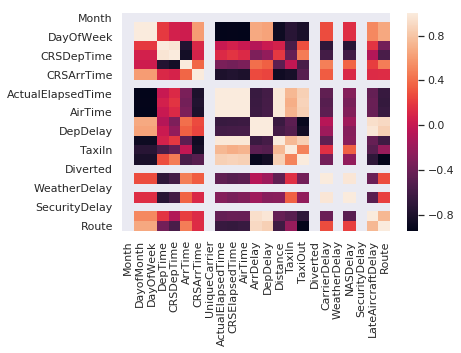

In [220]:
sns.heatmap(df.ix[list(five_least_delayed.index)].corr())

Above are the five least delayed routes,

In [216]:
five_most_delayed = delay_by_route.sort_values(by='TotalDelay')[delay_by_route.shape[0] - 5:delay_by_route.shape[0]]
five_most_delayed['Route'] = five_most_delayed['Route'].map(uniqueRouteDict)

In [217]:
five_most_delayed

,Route,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,TotalDelay
1492,HDN - ORD,39.363636,1.750000,46.193182,0.000000,34.465909,121.772727
1241,EGE - ORD,37.283333,4.233333,39.866667,0.000000,42.966667,124.350000
3763,VPS - MEM,89.763158,2.236842,11.236842,0.105263,28.842105,132.184211
3558,SMF - MSP,101.893939,4.848485,10.196970,0.000000,17.863636,134.803030
1239,EGE - DFW,40.836957,30.750000,14.543478,0.000000,49.826087,135.956522


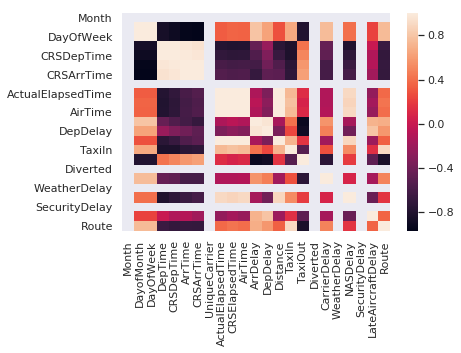

In [218]:
sns.heatmap(df.ix[list(five_most_delayed.index)].corr())

Above are the five most delayed routes,

## Airline Performance

In [219]:
delay_mean = (df.groupby('UniqueCarrier', as_index=False)
       .agg({'CarrierDelay':'mean', 'WeatherDelay':'mean','NASDelay':'mean','SecurityDelay':'mean','LateAircraftDelay':'mean'}))
delay_mean

delay_mean['TotalDelay'] = delay_mean['CarrierDelay'] + delay_mean['WeatherDelay'] + delay_mean['NASDelay'] + delay_mean['SecurityDelay'] + delay_mean['LateAircraftDelay']
delay_mean.sort_values(by='TotalDelay')

pd.DataFrame(df['UniqueCarrier'].value_counts())


,UniqueCarrier
17.0,201793
1.0,131224
11.0,96180
15.0,94801
14.0,85642
6.0,70775
18.0,68170
16.0,58090
5.0,58018
7.0,55832
